In [1]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [2]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [122219, 109279, 400391, 401537, 999961]

In [3]:
df_cpe_file = 'competencia_02_inflacion_adj_cpe.parquet'
df_ipc_file = 'competencia_02_inflacion_adj_ipc.parquet'
df_sin_adj_file = 'competencia_02.parquet'

### Test de ajuste por CPE

In [4]:
data = pl.scan_parquet(dataset_path + df_cpe_file).filter(pl.col("foto_mes") == 202106).collect()

In [5]:
data = data.to_pandas()

In [6]:
# corrijo los tipos de estas 2 columnas que se guardaron como string en el parquet

data[['tmobile_app', 'cmobile_app_trx']] = data[['tmobile_app', 'cmobile_app_trx']].astype('float')

In [7]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [8]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [9]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados (mismo modelo - 5 semillas distintas)

In [10]:
version = 'cpe'

modelos_folder = modelos_path + 'experimento'

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if 'experimento_cpe' in modelo]

In [11]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s109279.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s122219.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s400391.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s401537.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_cpe_v01_s999961.txt']

In [ ]:
ganancia_acumulada_cpe = []
ganancia_maxima_cpe = []
numero_envios_cpe = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada_cpe.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima_cpe.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios_cpe.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio = np.mean(ganancia_acumulada_cpe, axis=0)
ganancia_maxima_promedio = ganancia_acumulada_promedio.max()
numero_envios_promedio = np.where(ganancia_acumulada_promedio == ganancia_maxima_promedio)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio/1000000} millones y se alcanza con {numero_envios_promedio} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima_cpe)/1000000} millones y de {np.std(numero_envios_cpe)} envios')

En promedio la ganancia obtenida es 93.38 millones y se alcanza con 11691 envios
El desvio estandar de la ganancia maxima es de 1.9088813897149293 millones y de 971.377084349842 envios


In [ ]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima_cpe,
    'Numero de Envios': numero_envios_cpe,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,92876000,10051,122219
1,97174000,12637,109279
2,95214000,11797,400391
3,91756000,10211,401537
4,93366000,11141,999961


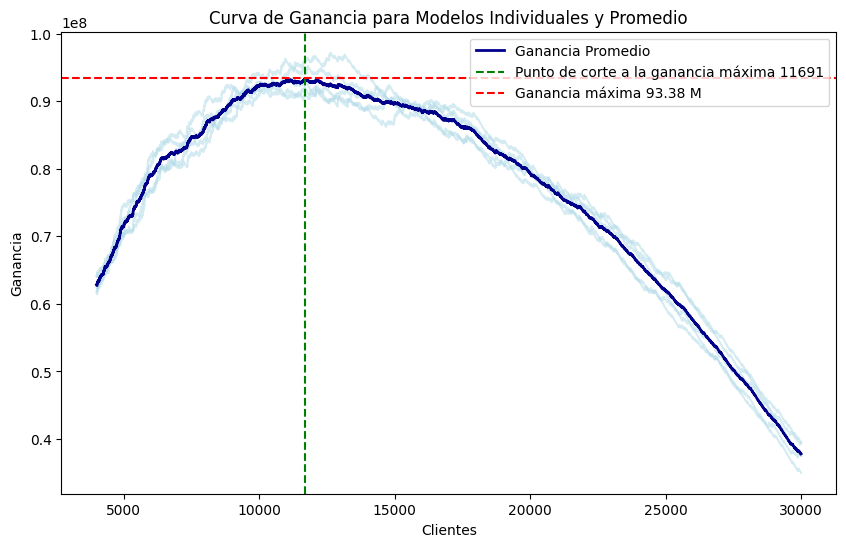

In [ ]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada_cpe:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio}'
)

plt.axhline(
    y=ganancia_maxima_promedio,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

### Test de ajuste por IPC

In [15]:
data = pl.scan_parquet(dataset_path + df_ipc_file).filter(pl.col("foto_mes") == 202106).collect()

In [16]:
data = data.to_pandas()

In [17]:
# corrijo los tipos de estas 2 columnas que se guardaron como string en el parquet

data[['tmobile_app', 'cmobile_app_trx']] = data[['tmobile_app', 'cmobile_app_trx']].astype('float')

In [18]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [19]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [20]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados (mismo modelo - 5 semillas distintas)

In [21]:
version = 'ipc'

modelos_folder = modelos_path + 'experimento'

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if 'experimento_ipc' in modelo]

In [22]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s109279.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s122219.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s400391.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s401537.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_ipc_v01_s999961.txt']

In [ ]:
ganancia_acumulada_ipc = []
ganancia_maxima_ipc = []
numero_envios_ipc = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada_ipc.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima_ipc.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios_ipc.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio_ipc = np.mean(ganancia_acumulada_ipc, axis=0)
ganancia_maxima_promedio_ipc = ganancia_acumulada_promedio_ipc.max()
numero_envios_promedio_ipc = np.where(ganancia_acumulada_promedio_ipc == ganancia_maxima_promedio_ipc)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio/1000000} millones y se alcanza con {numero_envios_promedio} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima_ipc)/1000000} millones y de {np.std(numero_envios_ipc)} envios')

En promedio la ganancia obtenida es 95.452 millones y se alcanza con 11475 envios
El desvio estandar de la ganancia maxima es de 0.7206261166513465 millones y de 1368.5459436935246 envios


In [ ]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima_ipc,
    'Numero de Envios': numero_envios_ipc,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,96880000,10199,122219
1,95354000,11257,109279
2,97307000,12898,400391
3,97188000,10595,401537
4,97111000,13766,999961


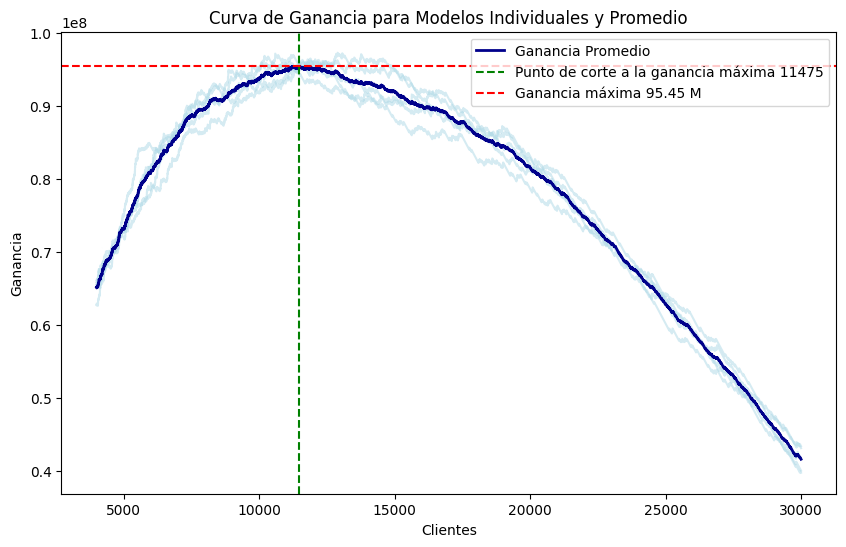

In [25]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio}'
)

plt.axhline(
    y=ganancia_maxima_promedio,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

### Test sin ajustar por ipc/cpe

In [26]:
data = pl.scan_parquet(dataset_path + df_sin_adj_file).filter(pl.col("foto_mes") == 202106).collect()

In [27]:
data = data.to_pandas()

In [28]:
# corrijo los tipos de estas 2 columnas que se guardaron como string en el parquet

data[['tmobile_app', 'cmobile_app_trx']] = data[['tmobile_app', 'cmobile_app_trx']].astype('float')

In [29]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [30]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [31]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados (mismo modelo - 5 semillas distintas)

In [32]:
version = 'sin_adj'

modelos_folder = modelos_path + 'experimento'

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if 'experimento_sin_adj' in modelo]

In [33]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s109279.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s122219.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s400391.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s401537.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/experimento/lgb_experimento_sin_adj_v01_s999961.txt']

In [34]:
ganancia_acumulada = []
ganancia_maxima = []
numero_envios = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio = np.mean(ganancia_acumulada, axis=0)
ganancia_maxima_promedio = ganancia_acumulada_promedio.max()
numero_envios_promedio = np.where(ganancia_acumulada_promedio == ganancia_maxima_promedio)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio/1000000} millones y se alcanza con {numero_envios_promedio} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima)/1000000} millones y de {np.std(numero_envios)} envios')

En promedio la ganancia obtenida es 93.205 millones y se alcanza con 11708 envios
El desvio estandar de la ganancia maxima es de 0.6287325027386448 millones y de 1063.3999435772037 envios


In [35]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima,
    'Numero de Envios': numero_envios,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,94675000,11554,122219
1,94535000,11814,109279
2,93198000,12805,400391
3,94276000,9971,401537
4,93282000,12913,999961


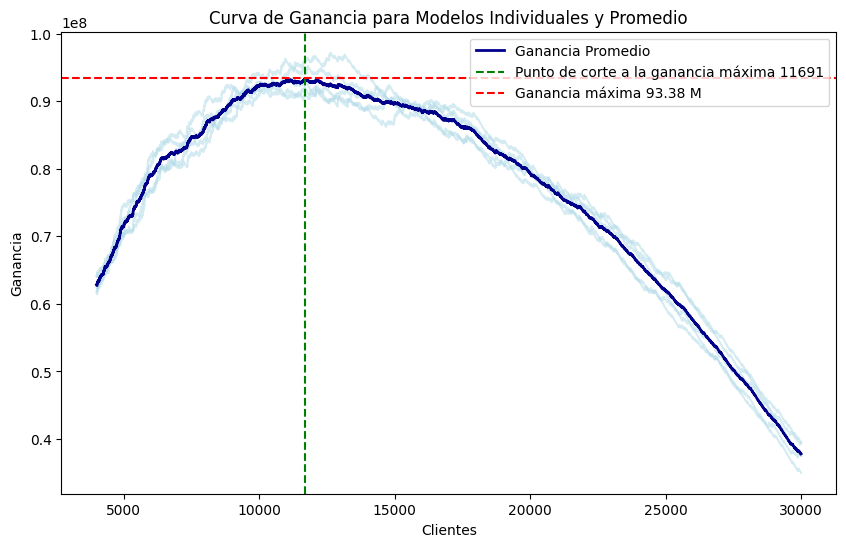

In [ ]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio}'
)

plt.axhline(
    y=ganancia_maxima_promedio,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()